# Episode 43. The First GAN Example

## Task: Train a Generative Adversarial Network that Outputs [1, 0, 1, 0]

### 1. Real Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# target function is noised version of [1, 0, 1, 0]
def generate_real_samples(n=10):
  dx = 0.2
  x = np.array([1.0-dx, 0.0, 1.0-dx, 0.0])
  x = x+dx*np.random.rand(n,4)
  # generate class labels: real=1
  y = np.ones((n, 1))
  return x,y

In [4]:
# generate sample data
x,y = generate_real_samples(10)
print(x)

[[0.91806918 0.02994886 0.88302639 0.08992712]
 [0.98461778 0.11583668 0.93293262 0.10352837]
 [0.9737006  0.07051605 0.9957809  0.19212383]
 [0.80406261 0.0406483  0.99687065 0.1930446 ]
 [0.92755147 0.12361607 0.84518238 0.10731669]
 [0.93627664 0.1998905  0.85516953 0.02302624]
 [0.84838464 0.05862135 0.83591727 0.07427591]
 [0.92102733 0.12677437 0.86619807 0.12215614]
 [0.9124072  0.1890898  0.81843344 0.10491957]
 [0.83170687 0.00439394 0.93937288 0.07668938]]


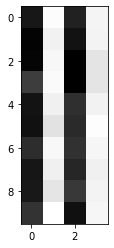

In [5]:
# show real data
plt.imshow(x,cmap='Greys',interpolation='None')

In [6]:
# generate n fake samples with class labels
def generate_fake(n):
	x = np.random.rand(n,4)
	# generate class labels: fake=0
	y = np.zeros((n, 1))
	return x, y

In [7]:
# generate sample data
xf,yf = generate_fake(10)
print(xf)

[[0.26223383 0.53294568 0.98987654 0.4116902 ]
 [0.23948407 0.72659683 0.95494668 0.40559603]
 [0.06646902 0.44604716 0.93713207 0.38845368]
 [0.95730455 0.22622794 0.1861652  0.18941046]
 [0.51116284 0.57327159 0.15529209 0.21386874]
 [0.7118074  0.13728609 0.28571485 0.42436418]
 [0.96851225 0.01937434 0.1197674  0.61057492]
 [0.66080089 0.79115248 0.72272166 0.31323167]
 [0.6858767  0.33493273 0.28475246 0.83797255]
 [0.05554323 0.02644502 0.63473896 0.37257676]]


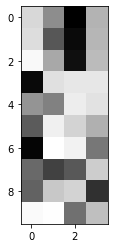

In [8]:
# show fake data
plt.imshow(xf,cmap='Greys',interpolation='None')

### 2. Define Discriminator

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [10]:
d_in = 4

In [11]:
# define the standalone discriminator model
def define_discriminator(n_inputs=4):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [12]:
# define the discriminator model
d_model = define_discriminator(d_in)
# summarize the model
d_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                125       
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


### 3. Train Discriminator

In [15]:
# train the discriminator model
def train_discriminator(model, n_epochs=300, n_batch=100):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)


In [ ]:
# fit the model
train_discriminator(d_model)

In [ ]:
# test discriminator: real=1
x1,y1 = generate_real_samples(5)
y1_pred = d_model.predict(x1)
print(y1)

In [ ]:
# test discriminator: fake=0
x2,y2 = generate_fake(5)
y2_pred = d_model.predict(x2)
print(y2)

### 4. Define Generator

In [20]:
n_batch = 10
latent_dim = 5
g_out = 4

In [21]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=4):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

In [22]:
# define the generator model
g_model = define_generator(latent_dim,g_out)
# summarize the model
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                90        
                                                                 
 dense_3 (Dense)             (None, 4)                 64        
                                                                 
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


### 5. Train Generator

In [23]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

In [24]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n, 1))
	return X, y

In [25]:
# predict outputs
x_gen,y_gen = generate_fake_samples(g_model, latent_dim, n_batch)

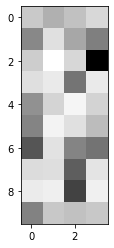

In [26]:
# show generator output
plt.imshow(x_gen,cmap='Greys',interpolation='None')

### 6. Define GAN

In [27]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [41]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)

In [44]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=100, n_eval=100):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

[[1.1036419  0.05606163 0.9109112  0.22017491]
 [0.8091551  0.04302312 0.8099662  0.11551551]
 [1.1104815  0.06684767 1.0398444  0.04906427]
 [1.0287684  0.12453613 0.9044044  0.12307488]
 [0.6907859  0.08675451 0.6585132  0.10878652]
 [0.8985368  0.07713385 0.8906744  0.06370806]
 [0.8795854  0.06770068 0.89310414 0.08201819]
 [0.7404354  0.02254511 0.6768963  0.11430764]
 [0.7001559  0.09468743 0.88342875 0.15675837]
 [0.9610189  0.04358491 0.98649484 0.08102803]]


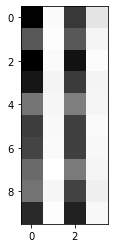

In [50]:
# test generator
x_ginput = generate_latent_points(latent_dim, 10)
x_gtest = generator.predict(x_ginput)
print(x_gtest)
# show generator output
plt.imshow(x_gtest,cmap='Greys',interpolation='None')

# SUMMARY

## Step 1. Define Neural Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [11]:
# Set Ket Parameters
n_epochs=1000
n_batch=100
n_eval=100
latent_dim = 5
g_out = 4
d_in = 4

In [3]:
# define the standalone discriminator model
def define_discriminator(n_inputs=4):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [4]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=4):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

In [5]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

## Step 2. Real & Fake Data

In [6]:
# target function is noised version of [1, 0, 1, 0]
def generate_real_samples(n=10):
  dx = 0.2
  x = np.array([1.0-dx, 0.0, 1.0-dx, 0.0])
  x = x+dx*np.random.rand(n,4)
  # generate class labels: real=1
  y = np.ones((n, 1))
  return x,y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n, 1))
	return X, y

## Step 3. Train Network

In [9]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)

In [13]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=100, n_eval=100):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = np.ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

In [14]:
# create the discriminator
discriminator = define_discriminator(d_in)
# create the generator
generator = define_generator(latent_dim,g_out)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, n_epochs, n_batch, n_eval)

99 1.0 0.6700000166893005
199 1.0 0.6499999761581421
299 0.05000000074505806 1.0
399 0.1599999964237213 0.9800000190734863
499 0.6899999976158142 0.6600000262260437
599 0.8299999833106995 0.5600000023841858
699 0.7099999785423279 0.4300000071525574
799 0.5299999713897705 0.550000011920929
899 0.36000001430511475 0.47999998927116394
999 0.33000001311302185 0.6299999952316284


[[0.8230494  0.10135699 0.8123342  0.08066786]
 [0.7696618  0.09331491 0.7860017  0.08498926]
 [1.0226302  0.14183065 1.0589412  0.16029292]
 [1.3833047  0.20243691 1.2998801  0.18765223]
 [0.88039225 0.1475288  0.8493495  0.15431595]
 [0.8778555  0.07658694 0.789683   0.05481561]
 [1.3500026  0.18567769 1.2112831  0.18848343]
 [1.1403332  0.12803747 1.0795754  0.11907785]
 [0.7909275  0.11064049 0.8182672  0.09281893]
 [0.978162   0.09241084 1.0214217  0.13777022]]


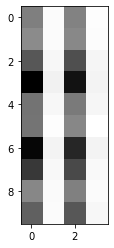

In [15]:
# test generator
x_ginput = generate_latent_points(latent_dim, 10)
x_gtest = generator.predict(x_ginput)
print(x_gtest)
# show generator output
plt.imshow(x_gtest,cmap='Greys',interpolation='None')